#  Forecast analysis to determine opportunities to trade CHWY stock using swing strategy.

 Swing strategy refers to trading both sides on the movements of any financial market.

In [573]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


#importing initial neccesary modules
import pandas as pd
import numpy as np
from datetime import timedelta
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import matplotlib.pyplot as plt
import yfinance as yf


#pd display format
pd.options.display.float_format = '{:.4f}'.format

# Import Data

In [574]:
# get stock data for Chewy and Amazon for Jun 14, 2016 to Nov 18, 2021
raw_data = yf.download(['CHWY','AMZN'], start = '2019-06-14', end = '2021-11-19')

[*********************100%***********************]  2 of 2 completed


In [579]:
#Validation data (5 business days)
results = yf.download(['CHWY'], start = '2021-11-19', end = '2021-11-28')

[*********************100%***********************]  1 of 1 completed


In [582]:
df = raw_data.copy()

In [583]:
true_p = results.Close.copy()

# Pre-processing data

In [584]:
true_p = true_p.rename('true price')

In [585]:
df['chwy'] = df.Close['CHWY']
df['amzn'] = df.Close['AMZN']

In [586]:
df.drop(['Adj Close','Close','High','Low','Open','Volume'],axis = 1, inplace = True)

In [587]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [588]:
#Normalized dataframe
norm = df.div(df.iloc[0]).mul(100)

In [589]:
#Returns
df_r = df[['chwy','amzn']].diff(1).mul(100).dropna()

In [590]:
#Tranning and test stock prices
size = int(len(df)*0.8)
train_p,test_p = df.iloc[:size],df.iloc[size:]

In [591]:
#Tranning and test returns sets
size = int(len(df_r)*0.8)
train_r,test_r = df_r.iloc[:size],df_r.iloc[size:]

# Exploratory data analysis

In [551]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 634 entries, 2019-06-17 to 2021-11-18
Freq: B
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   (chwy, )  634 non-null    float64
 1   (amzn, )  634 non-null    float64
dtypes: float64(2)
memory usage: 14.9 KB


In [592]:
df.describe()

,chwy,amzn
,,
count,635.0000,635.0000
mean,57.3843,2720.3863
std,25.3034,672.2167
min,22.1300,1676.6100
25%,32.2450,1908.8900
50%,56.2200,3092.9299
75%,77.6250,3286.0901
max,118.6900,3731.4099


In [594]:
#correclation between chwy and amzn returns
df_r.corr()

,,chwy,amzn
,,,
chwy,,1.0000,0.3106
amzn,,0.3106,1.0000


In [595]:
#test granger causality between chwy and amsn to check if multivariable forecast is feasable
from statsmodels.tsa.stattools import grangercausalitytests

granger_chwy = grangercausalitytests(df_r[['chwy','amzn']],26)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4509  , p=0.5022  , df_denom=630, df_num=1
ssr based chi2 test:   chi2=0.4531  , p=0.5009  , df=1
likelihood ratio test: chi2=0.4529  , p=0.5010  , df=1
parameter F test:         F=0.4509  , p=0.5022  , df_denom=630, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3398  , p=0.7120  , df_denom=627, df_num=2
ssr based chi2 test:   chi2=0.6851  , p=0.7100  , df=2
likelihood ratio test: chi2=0.6847  , p=0.7101  , df=2
parameter F test:         F=0.3398  , p=0.7120  , df_denom=627, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1640  , p=0.9206  , df_denom=624, df_num=3
ssr based chi2 test:   chi2=0.4975  , p=0.9194  , df=3
likelihood ratio test: chi2=0.4973  , p=0.9195  , df=3
parameter F test:         F=0.1640  , p=0.9206  , df_denom=624, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1812  , p=0.9481  

No causality found. Vector Autoregressive forecasting method not appropiate.

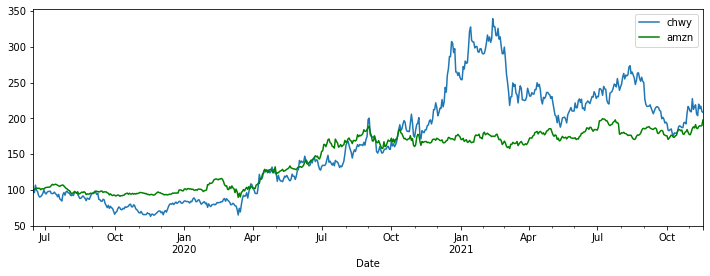

In [596]:
#Plot stock performance of chwy vs amzn
norm['chwy'].plot(figsize= (12,4))
norm['amzn'].plot(color = "green")
plt.legend()

In [597]:
#naive seasonal decomposition function
from statsmodels.tsa.seasonal import seasonal_decompose

def nsd_f(df):
    decomposition_mul = seasonal_decompose(df, model = 'multiplicative')
    trend = decomposition_mul.trend
    seasonal = decomposition_mul.seasonal
    residual = decomposition_mul.resid
 
    plt.figure(figsize=(12,6))
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='S')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Res',linestyle='dashed' )
    plt.legend(loc='upper left')
    plt.tight_layout()

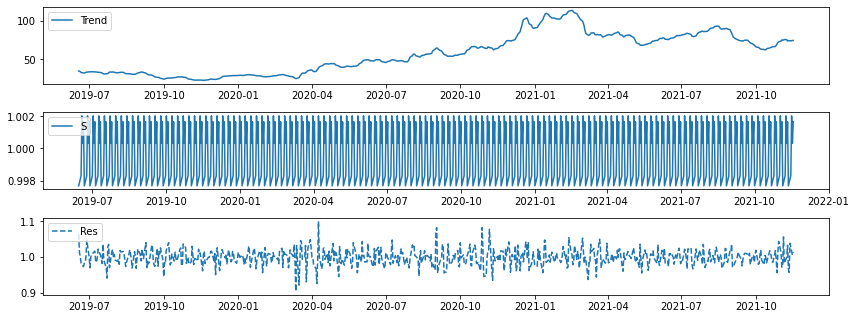

In [599]:
#decomposition chwy
nsd_f(df['chwy'])

In [600]:
#Determining stationarity for Chwy returns
sts.adfuller(df_r['chwy'])

(-9.250028836797794,
 1.5009186927451415e-15,
 8,
 625,
 {'1%': -3.440856177517568, '5%': -2.86617548304384, '10%': -2.56923863104},
 8409.318011913972)

The process has become stationary.

Text(0.5, 1.0, 'PACF')

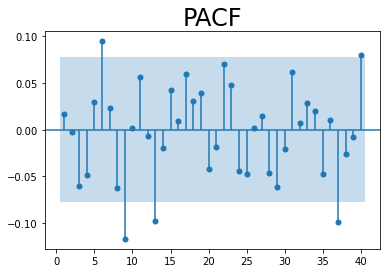

In [675]:
#PACF reuturns
sgt.plot_pacf(df_r['chwy'], lags = 40 , zero = False, alpha=0.05 )
plt.title('PACF', size = 24) 

Text(0.5, 1.0, 'ACF')

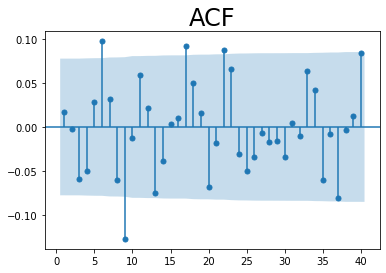

In [602]:
#ACF reuturns
sgt.plot_acf(df_r['chwy'], lags = 40 , zero = False, alpha=0.05 )
plt.title('ACF', size = 24) 

# Holt Extended Simple Exponential Smoothing

Method selected due to no seasonality and damped trend obseved.

In [647]:
fithses = Holt(df['chwy'],damped_trend = True).fit()
fcasthses = fithses.forecast(5)

In [648]:
#last price in the data set
df['chwy'][-1]

72.91999816894531

In [651]:
# 5 days forecast into the future
fcasthses = pd.DataFrame(fcasthses.values,index = true_p.index, columns= ['Holts fcast Chwy'])
fcasthses

,Holts fcast Chwy
Date,
2021-11-19,72.9200
2021-11-22,72.9200
2021-11-23,72.9200
2021-11-24,72.9200
2021-11-26,72.9200


In [654]:
fithses.model.params['smoothing_level']

0.9999999850988388

<Figure size 576x504 with 0 Axes>

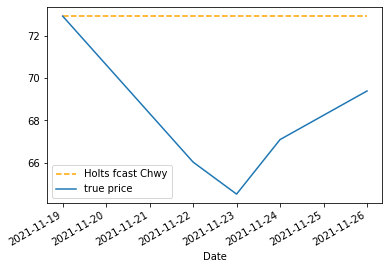

In [652]:
plt.figure(figsize=(8,7))
fcasthses.plot(style= '--', color = 'orange')
true_p.plot()
plt.legend(loc = 'lower left')

In [209]:
print('RMSE:',np.sqrt(mean_squared_error(true_p,fcasthses)))

RMSE: 6.264355571033759


### Results:

The Holt model does not provide the necessary information to fomulate a swing strategy. It suggests that today's price.

# Auto ARIMA

In [278]:
#chwy model prices
from pmdarima import auto_arima

autoarima_model = auto_arima(train_p.chwy, max_order = None
                            , max_p = 25, max_q = 25, max_d = 2, n_jobs = -1)

In [277]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1136.933
Date:                Sun, 28 Nov 2021   AIC                           2275.866
Time:                        20:04:25   BIC                           2280.094
Sample:                             0   HQIC                          2277.524
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.1917      0.194     26.724      0.000       4.811       5.572
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):               279.85
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):              11.98   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX(0,1,0) suggests the process is a random walk, where the current observation is equal to the previous observation with a random step up or down.

In [520]:
fcast_arima = autoarima_model.predict(n_periods = 5)

fcast_arima = pd.DataFrame(fcast_arima
                                  ,index = true_p.index ,columns = [ 'fcast CHWY'])

In [529]:
#Frecast
fcast_arima

,fcast CHWY
Date,
2021-11-19,72.9300
2021-11-22,72.9300
2021-11-23,72.9300
2021-11-24,72.9300
2021-11-26,72.9300


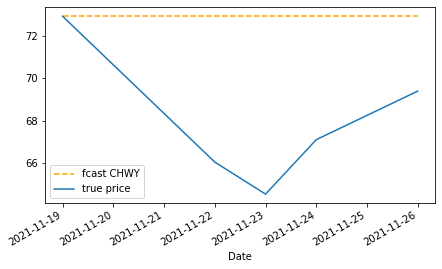

In [680]:
plt.figure(figsize=(7,4))
fcast_arima['fcast CHWY'].plot(style= '--', color = 'orange')
true_p.plot()
plt.legend()

In [273]:
print('RMSE:',np.sqrt(mean_squared_error(true_p,fcast_arima)))

RMSE: 6.272485346518103


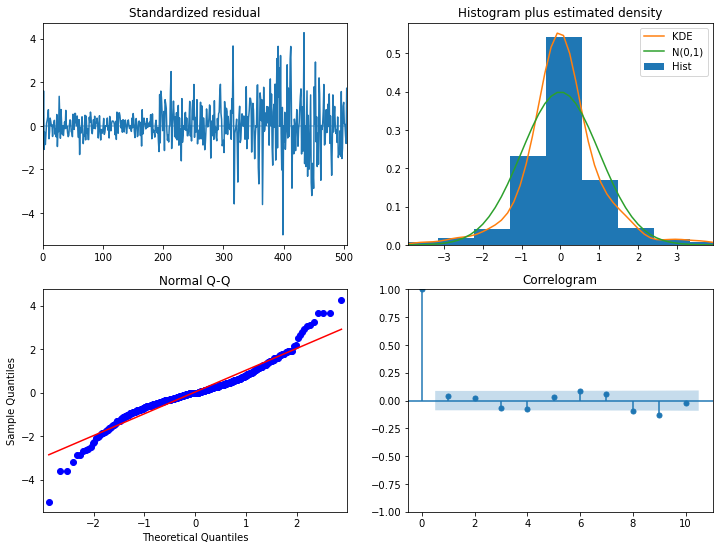

In [280]:
autoarima_model.plot_diagnostics(figsize=(12,9))
plt.show()

Residuals suggests that the model has done a satisfactory job in removing biases.

### Results:

The Auto ARIMA does not provide the necessary information to fomulate a swing strategy. It suggests that today's price is the best estimation for tomorrow's price.

# Volatility

## GARCH

In [508]:
from arch import arch_model

In [509]:
#transform data to show volatility
df_r['chwy_r^2'] = df_r.chwy.mul(df_r.chwy)

<AxesSubplot:title={'center':'Chewy Stock Volatility'}, xlabel='Date'>

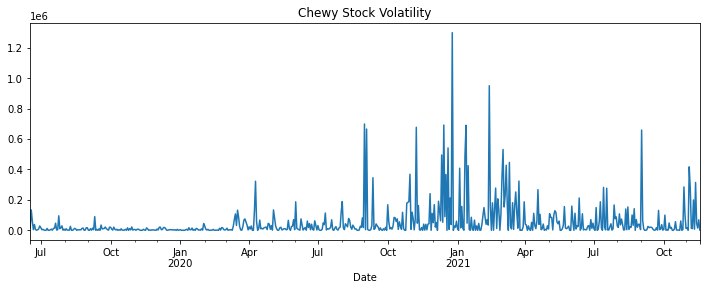

In [510]:
# inspect visually
df_r['chwy_r^2'].plot(figsize = (12,4), title = 'Chewy Stock Volatility')

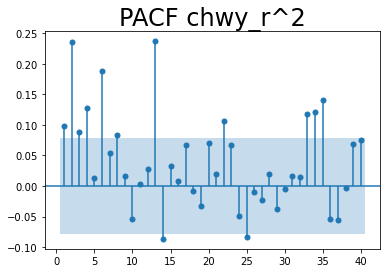

In [288]:
sgt.plot_pacf(df_r['chwy_r^2'], lags = 40 ,method ='ols', zero = False, alpha=0.05 )
plt.title('PACF chwy_r^2', size = 24)
plt.show()  

In [285]:
model_garch = arch_model(df_r['chwy'], mean ='AR', lags = [9] ,dist = 'ged', p=1, q=1)
results_arch = model_garch.fit(5)
results_arch.summary()

Iteration:      5,   Func. Count:     42,   Neg. LLF: 4154.811301857708
Iteration:     10,   Func. Count:     80,   Neg. LLF: 4154.0426994805075
Iteration:     15,   Func. Count:    115,   Neg. LLF: 4154.041578957555
Iteration:     20,   Func. Count:    150,   Neg. LLF: 4153.676864938327
Iteration:     25,   Func. Count:    188,   Neg. LLF: 4150.6609270642975
Iteration:     30,   Func. Count:    224,   Neg. LLF: 4150.199699670753
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4150.199669497564
            Iterations: 33
            Function evaluations: 246
            Gradient evaluations: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                               chwy   R-squared:                       0.015
Mean Model:                                    AR   Adj. R-squared:                  0.014
Vol Model:                                  GARCH   Log-Likelihood:               -4150.20
Distribution:      Generalized Error Distribution   AIC:                           8312.40
Method:                        Maximum Likelihood   BIC:                           8339.03
                                                    No. Observations:                  625
Date:                            Sun, Nov 28 2021   Df Residuals:                      623
Time:                                    20:07:54   Df Model:                            2
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.3381      5.212  6.487e-02      0.948    [ -9.877, 10.554]
chwy[9]       -0.1078  3.672e-02     -2.936  3.326e-03 [ -0.180,-3.584e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        184.1422    200.054      0.920      0.357 [-2.080e+02,5.762e+02]
alpha[1]       0.0768  4.231e-02      1.816  6.941e-02   [-6.102e-03,  0.160]
beta[1]        0.9232  4.465e-02     20.675  5.826e-95      [  0.836,  1.011]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.3656      0.118     11.595  4.374e-31 [  1.135,  1.596]
========================================================================

Covariance estimator: robust
"""

In [289]:
#define dates
start_date = test_r.head(1).index[0]
end_date = test_r.tail(1).index[0] 

In [291]:
#fit model
res_garch = model_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     79,   Neg. LLF: 3283.7012918023356
Iteration:     20,   Func. Count:    149,   Neg. LLF: 3283.665502712439
Iteration:     30,   Func. Count:    219,   Neg. LLF: 3281.732112023782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3281.7321097344766
            Iterations: 32
            Function evaluations: 234
            Gradient evaluations: 32


In [292]:
#Predict vertically
pred_garch = res_garch.forecast(horizon = 1)

Text(0.5, 1.0, 'Volatility Predictions')

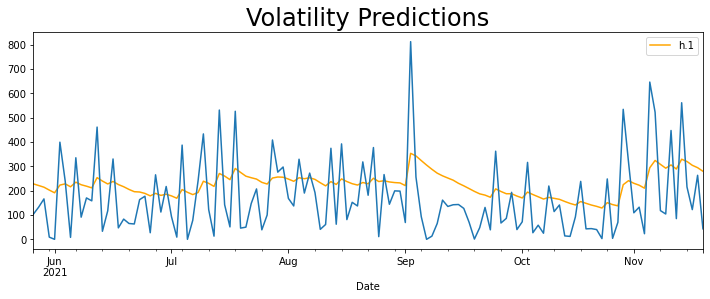

In [656]:
#show predictions vs actuals
np.sqrt(pred_garch.residual_variance[ start_date: ]).plot(figsize = (20,5), color = 'orange')
test_r.chwy.abs().plot(figsize = (12,4))
plt.title('Volatility Predictions', size = 24)

In [659]:
#Forecst horizontally based on last instance
pred = 5
forecast_vol = res_garch.forecast(horizon = pred)
forecast_vol = forecast_vol.residual_variance.values[-1:]

In [660]:
#transform forecast into dataframe with date index
forecast_vol = pd.DataFrame(forecast_vol.flatten(),index = true_p.index,columns=['Forecast vol'])

<AxesSubplot:xlabel='Date'>

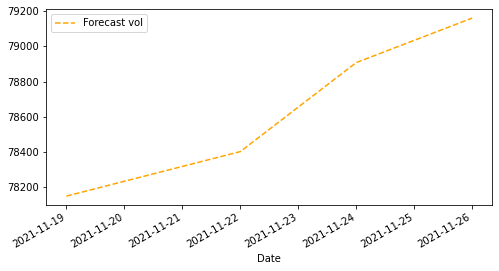

In [661]:
#visualize forecasted volatity
forecast_vol.plot(figsize=(8,4),linestyle='--', color = 'orange',legend=True )

Model suggests volatility will increase in the next 5 days.

# LSTM 

In [662]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [663]:
#scale data
scaler = MinMaxScaler(feature_range = (0, 1))
train_lstm = scaler.fit_transform(np.array(train_p[['chwy']])) 
test_lstm = scaler.fit_transform(np.array(test_p[['chwy']]))

In [664]:
def create_dataset(d, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(d) - look_back - 1):
        a = d[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(d[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [667]:
#reshape 
look_back = 60
X_train, Y_train = create_dataset(train_lstm, look_back)
X_test, Y_test = create_dataset(test_lstm, look_back)

In [668]:
#reshape input to be [samples, look_back steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [669]:
#create stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (look_back,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss ='mse', optimizer = 'adam')

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


In [344]:
model_his = model.fit(X_train, Y_train, epochs = 350, batch_size = 72,  
                   validation_data = (X_test, Y_test), verbose = 1,
                   shuffle = False)

Epoch 1/350
7/7 [==============================] - 10s 710ms/step - loss: 0.0153 - val_loss: 0.0763
Epoch 2/350
7/7 [==============================] - 1s 116ms/step - loss: 0.0307 - val_loss: 0.0391
Epoch 3/350
7/7 [==============================] - 1s 117ms/step - loss: 0.0083 - val_loss: 0.0678
Epoch 4/350
7/7 [==============================] - 1s 114ms/step - loss: 0.0088 - val_loss: 0.0507
Epoch 5/350
7/7 [==============================] - 1s 116ms/step - loss: 0.0095 - val_loss: 0.0501
Epoch 6/350
7/7 [==============================] - 1s 117ms/step - loss: 0.0056 - val_loss: 0.0582
Epoch 7/350
7/7 [==============================] - 1s 132ms/step - loss: 0.0086 - val_loss: 0.0462
Epoch 8/350
7/7 [==============================] - 1s 121ms/step - loss: 0.0052 - val_loss: 0.0552
Epoch 9/350
7/7 [==============================] - 1s 117ms/step - loss: 0.0063 - val_loss: 0.0457
Epoch 10/350
7/7 [==============================] - 1s 117ms/step - loss: 0.0054 - val_loss: 0.0496
Epoch 11

7/7 [==============================] - 1s 114ms/step - loss: 0.0022 - val_loss: 0.0156
Epoch 84/350
7/7 [==============================] - 1s 113ms/step - loss: 0.0021 - val_loss: 0.0154
Epoch 85/350
7/7 [==============================] - 1s 114ms/step - loss: 0.0020 - val_loss: 0.0150
Epoch 86/350
7/7 [==============================] - 1s 114ms/step - loss: 0.0021 - val_loss: 0.0146
Epoch 87/350
7/7 [==============================] - 1s 114ms/step - loss: 0.0019 - val_loss: 0.0144
Epoch 88/350
7/7 [==============================] - 1s 115ms/step - loss: 0.0020 - val_loss: 0.0141
Epoch 89/350
7/7 [==============================] - 1s 113ms/step - loss: 0.0018 - val_loss: 0.0138
Epoch 90/350
7/7 [==============================] - 1s 113ms/step - loss: 0.0021 - val_loss: 0.0138
Epoch 91/350
7/7 [==============================] - 1s 114ms/step - loss: 0.0019 - val_loss: 0.0132
Epoch 92/350
7/7 [==============================] - 1s 115ms/step - loss: 0.0031 - val_loss: 0.0136
Epoch 93/350


7/7 [==============================] - 1s 108ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 165/350
7/7 [==============================] - 1s 108ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 166/350
7/7 [==============================] - 1s 109ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 167/350
7/7 [==============================] - 1s 111ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 168/350
7/7 [==============================] - 1s 107ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 169/350
7/7 [==============================] - 1s 109ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 170/350
7/7 [==============================] - 1s 109ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 171/350
7/7 [==============================] - 1s 107ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 172/350
7/7 [==============================] - 1s 111ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 173/350
7/7 [==============================] - 1s 110ms/step - loss: 0.0014 - val_loss: 0.0078
Epoc

7/7 [==============================] - 1s 131ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 246/350
7/7 [==============================] - 1s 125ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 247/350
7/7 [==============================] - 1s 126ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 248/350
7/7 [==============================] - 1s 117ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 249/350
7/7 [==============================] - 1s 119ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 250/350
7/7 [==============================] - 1s 135ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 251/350
7/7 [==============================] - 1s 133ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 252/350
7/7 [==============================] - 1s 121ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 253/350
7/7 [==============================] - 1s 120ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 254/350
7/7 [==============================] - 1s 118ms/step - loss: 0.0015 - val_loss: 0.0054
Epoc

Epoch 325/350
7/7 [==============================] - 1s 155ms/step - loss: 7.1383e-04 - val_loss: 0.0051
Epoch 326/350
7/7 [==============================] - 1s 126ms/step - loss: 7.1289e-04 - val_loss: 0.0051
Epoch 327/350
7/7 [==============================] - 1s 123ms/step - loss: 7.1197e-04 - val_loss: 0.0051
Epoch 328/350
7/7 [==============================] - 1s 117ms/step - loss: 7.1108e-04 - val_loss: 0.0051
Epoch 329/350
7/7 [==============================] - 1s 119ms/step - loss: 7.1020e-04 - val_loss: 0.0051
Epoch 330/350
7/7 [==============================] - 1s 132ms/step - loss: 7.0935e-04 - val_loss: 0.0051
Epoch 331/350
7/7 [==============================] - 1s 128ms/step - loss: 7.0851e-04 - val_loss: 0.0051
Epoch 332/350
7/7 [==============================] - 1s 139ms/step - loss: 7.0769e-04 - val_loss: 0.0051
Epoch 333/350
7/7 [==============================] - 1s 144ms/step - loss: 7.0690e-04 - val_loss: 0.0050
Epoch 334/350
7/7 [==============================] - 1s

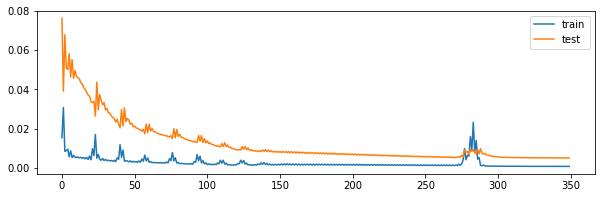

In [346]:
plt.figure(figsize=(10,3))
plt.plot(model_his.history['loss'], label = 'train')
plt.plot(model_his.history['val_loss'], label = 'test')
plt.legend()

In [347]:
# predict to observe performance
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [348]:
#Reshape data
Y_train_real = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_real = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [349]:
#Performance trainning
np.sqrt(mean_squared_error(Y_train_real, train_predict))

0.8991592708366927

In [350]:
#Performance test
np.sqrt(mean_squared_error(Y_test_real, test_predict))

2.416710581415822

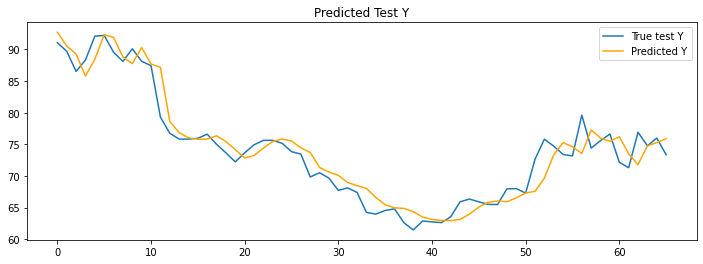

In [505]:
plt.figure(figsize=(12,4))
plt.plot(Y_test_real, label='True test Y')
plt.plot(test_predict, label='Predicted Y', color='orange')
plt.legend()
plt.title('Predicted Test Y')
plt.show()

In [389]:
lst_output = []
n_steps = 60
fcast_days = 5
i = 0
x_input = test_lstm[len(test_lstm) - n_steps :].reshape(1,-1)
temp_input = x_input[0].tolist()

while (i < fcast_days):
    
    if(len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        print('----------------------------------')
        print('{} day input {}'.format(i+1, x_input))
        print('----------------------------------')
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input, verbose = 0)
        print('{} day ouput {}'.format(i+1, scaler.inverse_transform(yhat)))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape(1,-1)
        yhat = model.predict(x_input, verbose = 0)

        print('{} day ouput {}'.format(i+1, scaler.inverse_transform(yhat)))
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1

1 day ouput [[73.251144]]
----------------------------------
2 day input [0.83644863 0.77862165 0.75846971 0.52132008 0.44655379 0.41939257
 0.41939257 0.42318922 0.44217291 0.39515186 0.35572433 0.31425242
 0.35601645 0.39310747 0.41355153 0.41384343 0.39982486 0.36156536
 0.35017519 0.24445103 0.26401873 0.23890189 0.18253506 0.19421735
 0.17318927 0.08089966 0.07301402 0.08995333 0.09725473 0.03329438
 0.         0.0411799  0.03709114 0.0335865  0.0604556  0.1299651
 0.14252329 0.12967298 0.11799069 0.11711456 0.18954434 0.19071259
 0.17026876 0.3262266  0.41880855 0.38697432 0.34842293 0.34170576
 0.53037397 0.37792066 0.41238328 0.44275714 0.31220803 0.28738331
 0.4512268  0.38843469 0.42406557 0.34725468 0.33469626 0.34436756]
----------------------------------
2 day ouput [[73.13712]]
----------------------------------
3 day input [0.77862165 0.75846971 0.52132008 0.44655379 0.41939257 0.41939257
 0.42318922 0.44217291 0.39515186 0.35572433 0.31425242 0.35601645
 0.39310747 0.41

# Results

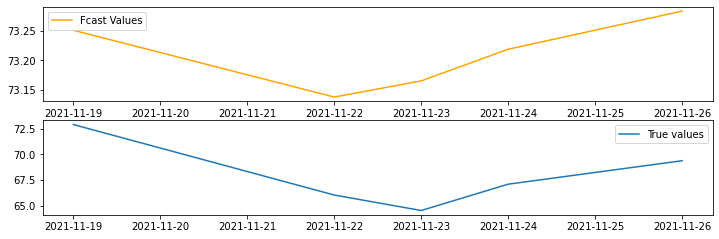

In [501]:
plt.figure(figsize=(12,8))
plt.subplot(412)
plt.plot(fcast_lstm,label='Fcast Values', color ='orange')
plt.legend()
plt.subplot(413)
plt.plot(true_p, label='True values')
plt.legend()

In [459]:
#Performance
np.sqrt(mean_squared_error(true_p, fcast_lstm))

5.960514859491295

<AxesSubplot:xlabel='Date'>

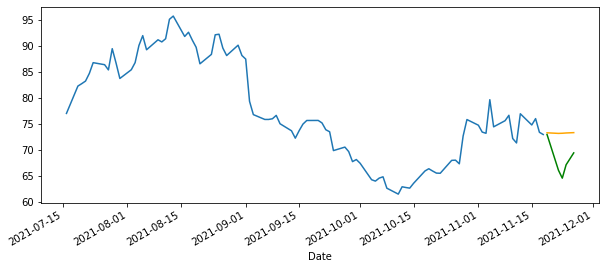

In [489]:
plt.figure(figsize=(10,4))
fcast_lstm['fcast chwy'].plot(color = 'orange')
df['chwy'][-90:].plot()
true_p.plot(color ='green')


# Conclusion:

Random walk models predict that all future values will equal the last observed value. CHWY stock process seems to be a random walk which assumes that in each period, the stock price takes a random step away from its previous value.  Generally, such models are not adequate for swing strategies. However, the following was observed:

1- For the forecasted period, the LSTM model performed well in predicting the direction of daily stock price movements. Accurate prediction of direction is useful in the development of swing strategies.

2- For the forecasted period, the GARCH model performed well in predicting return's volatility. Accurate volatility prediction is useful in the development of risk mitigation and swing trading strategies. 

Trades:

11/18/2021 -- Enter short position at closing price 72.92 
              Return: +10%
              
11/22/2021 -- Enter long position at closing price  66.04
              Return: +5%

wins ratio = 100%